In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!git clone https://github.com/tensorflow/models/

In [0]:
#Necessary packages are installed
!pip install pillow
!pip install lxml
!pip install Cython
!pip install jupyter
!pip install matplotlib
!pip install pandas
!pip install utils
!pip install opencv-python
!pip  install tensorboard==1.14.0
!pip  install tensorflow-estimator==1.14.0
!pip  install tensorflow-gpu==1.14.0
!apt-get install -qq protobuf-compiler python-tk
!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive
!pip install -q pycocotools

In [0]:
#!pip  install tensorboard==1.14.0
#!pip  install tensorflow-estimator==1.14.0
#!pip  install tensorflow-gpu==1.14.0

In [0]:
!protoc object_detection/protos/*.proto --python_out=.

In [0]:
import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

In [0]:
!python3 setup.py build
!python3 setup.py install

In [0]:
!python3 generate_tfrecord.py --csv_input=data/train_labels.csv --output_path=data/train.record --image_dir=images/train

In [0]:
 !python3 generate_tfrecord.py --csv_input=data/test_labels.csv --output_path=data/test.record --image_dir=images/test

In [0]:
!wget http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_v2_coco_2018_01_28.tar.gz

In [0]:
!tar -xvzf faster_rcnn_inception_v2_coco_2018_01_28.tar.gz

In [0]:
!cp -avr /content/Edge/data /content/models/research/object_detection

!cp -avr /content/Edge/images /content/models/research/object_detection

#!cp -avr /content/Edge/training /content/models/research/object_detection

!cp -avr /content/Edge/faster_rcnn_inception_v2_coco_2018_01_28 /content/models/research/object_detection

In [0]:
!cp -avr /content/drive/My\ Drive/training /content/models/research/object_detection

In [0]:
%cd /content/models/research/object_detection

!python3 /content/models/research/object_detection/legacy/train.py --logtostderr --train_dir=training/ --pipeline_config_path=training/faster_rcnn_inception_v2_coco.config

In [0]:
#!python3 /content/models/research/object_detection/legacy/train.py --logtostderr --train_dir=training/ --pipeline_config_path=training/faster_rcnn_inception_v2_coco.config

In [0]:
!python3 export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path training/faster_rcnn_inception_v2_coco.config \
    --trained_checkpoint_prefix training/model.ckpt-18479\
    --output_directory edge_compute 
#edge_compute = our saved model

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image


sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')

In [0]:
# This is needed to display the images.
#%matplotlib inline

In [0]:
from utils import label_map_util
from utils import visualization_utils as vis_util

In [0]:
MODEL_NAME = 'edge_compute'

PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

PATH_TO_LABELS = os.path.join('training', 'edge.pbtxt')

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [0]:
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}.jpg'.format(i)) for i in range(1, 2) ]

IMAGE_SIZE = (12, 8)

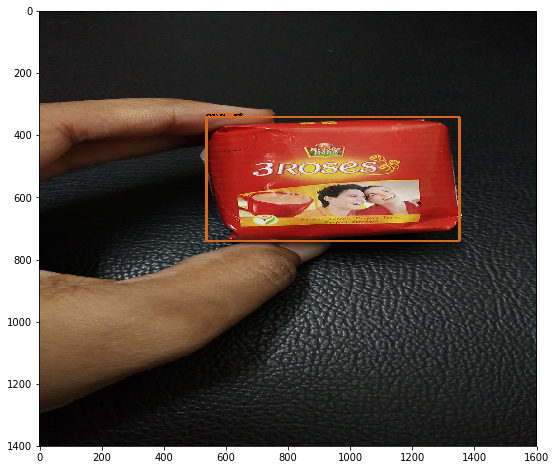

In [0]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    
    
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      
      
      image_np = load_image_into_numpy_array(image)
      
      image_np_expanded = np.expand_dims(image_np, axis=0)
      
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      
      
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)

In [0]:
def GetClassName(data):
   for cl in data:
    return cl['name']
data = [category_index.get(value) for index,value in enumerate(classes[0]) if scores[0,index] > 0.9]

print(GetClassName(data))

3roses-small


In [0]:
print([category_index.get(index) for index,value in enumerate(classes[0]) if scores[0,index]>0.5])
print(boxes.shape)
print(num_detections)